# 🌐 Connect Colab to Google Drive


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/

# 0) Prepare environment

## ⚙️ Settings

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import random
import torch

# Make experiment repeatable
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.random.manual_seed(SEED)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

## Load RAG 12000 dataset
The dataset constitutes a triple featured collection, with each entry comprising three distinct fields: context, question, and answer. It is specifically designed to support the development of models optimized for Retrieval-Augmented Generation (RAG). The dataset includes 12,000 entries, all in English.

Each data instance consists of a context passage, a question formulated based on the context, and a corresponding answer. The context is sourced from the Falcon RefinedWeb corpus, while the question and answer pairs are generated using the GPT-4 language model.
The dataset is already partitioned in training and test set with a 80-20 split ratio.

In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
from datasets import load_dataset, concatenate_datasets

# Load the RAG dataset from Hugging Face
dataset = load_dataset("neural-bridge/rag-dataset-12000")

train_set = dataset["train"]  # Train split
test_set = dataset["test"]  # Test split

## Clean the data
Remove examples where any field is empty or just whitespace from both train set and test set. As a result 2 samples are removed from the train set and 1 sample is removed from the test set.

In [ ]:
# Remove examples where any field is empty or just whitespace from both train set and test set
print(f"Original size train: {len(train_set)}")
train_set = train_set.filter(lambda example: bool(example["context"] is not None and example["context"].strip()))
train_set = train_set.filter(lambda example: bool(example["question"] is not None and example["question"].strip()))
train_set = train_set.filter(lambda example: bool(example["answer"] is not None and example["answer"].strip()))
print(f"Size train after removing NaNs: {len(train_set)}\n")

print(f"Original size test: {len(test_set)}")
test_set = test_set.filter(lambda example: bool(example["context"] is not None and example["context"].strip()))
test_set = test_set.filter(lambda example: bool(example["question"] is not None and example["question"].strip()))
test_set = test_set.filter(lambda example: bool(example["answer"] is not None and example["answer"].strip()))
print(f"Size train after removing NaNs: {len(test_set)}")

Original size train: 9600


Filter:   0%|          | 0/9600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9598 [00:00<?, ? examples/s]

Size train after removing NaNs: 9598

Original size test: 2400


Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2399 [00:00<?, ? examples/s]

Size train after removing NaNs: 2399


We also build the full set consisting of both train and test cleaned samples.

In [ ]:
full_set = concatenate_datasets([train_set, test_set])

## Build questions and contexts corpuses
Every filtered row contains a distinct context document while there are a few repeated questions.

In [ ]:
print(f"Total rows (train + test): {len(full_set)}")
print(f"Unique context docs: {len(set(full_set['context']))}")
print(f"Unique questions: {len(set(full_set['question']))}")

doc_corpus = full_set["context"]  # list of strings
question_corpus = list(set(full_set["question"])) # list of strings (eliminate duplicates)

Total rows (train + test): 11997
Unique context docs: 11997
Unique questions: 11983


# 1) 🔎 Preliminary Analysis
We use pandas dataframes to simplify data manipulation.

In [ ]:
df_train = train_set.to_pandas()
df_test = test_set.to_pandas()
df_tot = pd.concat([df_train, df_test], ignore_index=True)

# len(df_train), len(df_test), len(df_tot)

Visualize first 5 samples.

In [ ]:
df_tot.head(5)

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...


## Fields length correlation
Visualize the Pearson correlation coefficient between the lengths of the 3 fields in the dataset (context, question, answer).

In [ ]:
# Add length column for each field
# Use apply(lambda x: len(x.split())) for word count instead of characters
df_tot['question_len'] = df_tot['question'].apply(len)
df_tot['answer_len'] = df_tot['answer'].apply(len)
df_tot['context_len'] = df_tot['context'].apply(len)

In [ ]:
df_tot[['question_len', 'answer_len', 'context_len']].corr()

,question_len,answer_len,context_len
question_len,1.000000,0.127736,0.074890
answer_len,0.127736,1.000000,0.168333
context_len,0.074890,0.168333,1.000000


There is no significant correlation between the lengths of any pair of fields. The highest (yet weak) correlation is between the context length and the answer length.

## Documents length
**We begin by analysing the docs *corpus consisting of the context doc*s in the dataset.** Some statistics about the documents length.

In [ ]:
print("Statistics on the contexts: ")
print(df_tot["context_len"].describe())

Statistics on the contexts: 
count    11997.000000
mean      3437.894390
std       1612.886261
min        271.000000
25%       2080.000000
50%       3364.000000
75%       4698.000000
max       9156.000000
Name: context_len, dtype: float64


Now let's visualize the distribution of the length of the documents

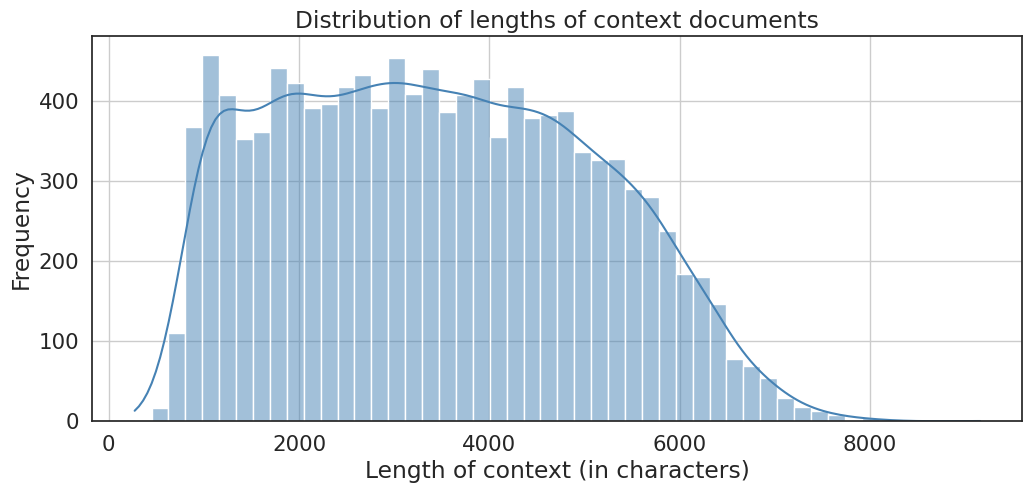

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df_tot["context_len"], bins=50, kde=True, color='steelblue')
plt.title("Distribution of lengths of context documents")
plt.xlabel("Length of context (in characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## TF-IDF vectorization
Fit the vectorizer to the context documents corpus.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=3, stop_words='english', max_features=5000)
vectorizer.fit(doc_corpus)

TfidfVectorizer(max_df=0.8, max_features=5000, min_df=3, stop_words='english')

Obtain vocabulary and print its size.

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(len(vocab))

5000


Build the tf-idf signatures of the context documents. Show the average number of features for each document.

In [ ]:
X = vectorizer.transform(doc_corpus)  # Matrix (12000, 5000) containing the docs tf-idf signatures
vocab_count_per_doc = (X != 0).sum(axis=1)  # Matrix (12000, 1) containing the non-zero entries in the docs signatures
vocab_count_per_doc = np.array(vocab_count_per_doc).flatten()  # Convert to 1D array

print("Avg features count per doc:", vocab_count_per_doc.mean()) # Different features contained in a doc on average

Avg features count per doc: 143.29315662248897


## Clustering w/ K-Means
** Cit riguardo al context su cui si basa analisi
We aim to cluster the context documents to identify patterns using the kmeans algorithm. We exploit the previously computed tf-idf vectorization of the documents.

We apply the elbow rule to identify an appropriate value for the number of clusters k. This consists of applying the algorithm for increasing values of k and choose the value after which improvements become marginal.

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 60)  # Can be changed
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, max_iter=1000, n_init=10)
    # Requires X to be defined
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

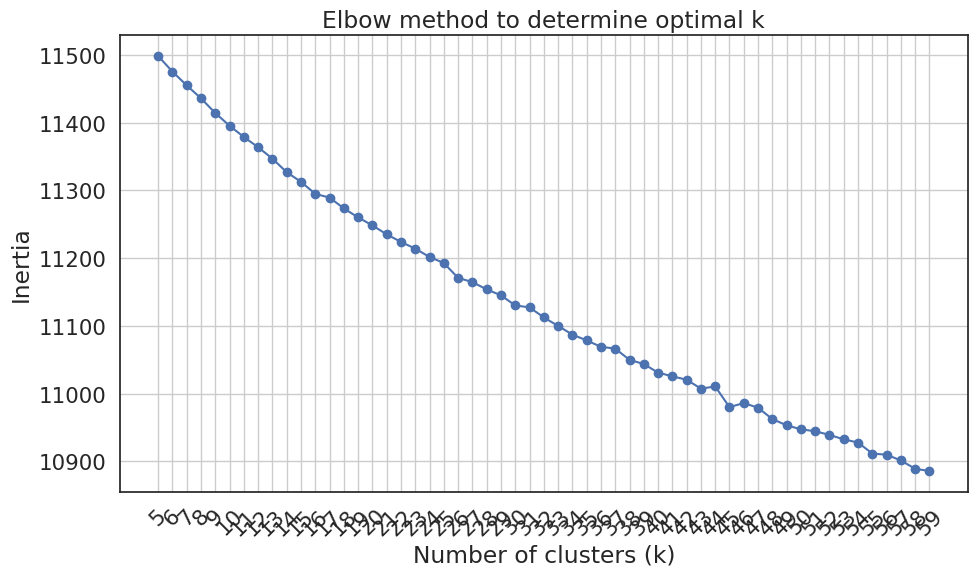

In [ ]:
# Plot for elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xticks(k_range, rotation=45)
plt.grid(True)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method to determine optimal k')
plt.tight_layout()
plt.show()

The plot doesn't present an elbow. Inertia seems to keep decreasing without ever plateauing. We try using a different clustering quality metric to identify the optimal k, ie. the silhouette score.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_range = range(5, 60)  # Can be changed
scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, max_iter=1000, n_init=10)
    # Requires X to be defined
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

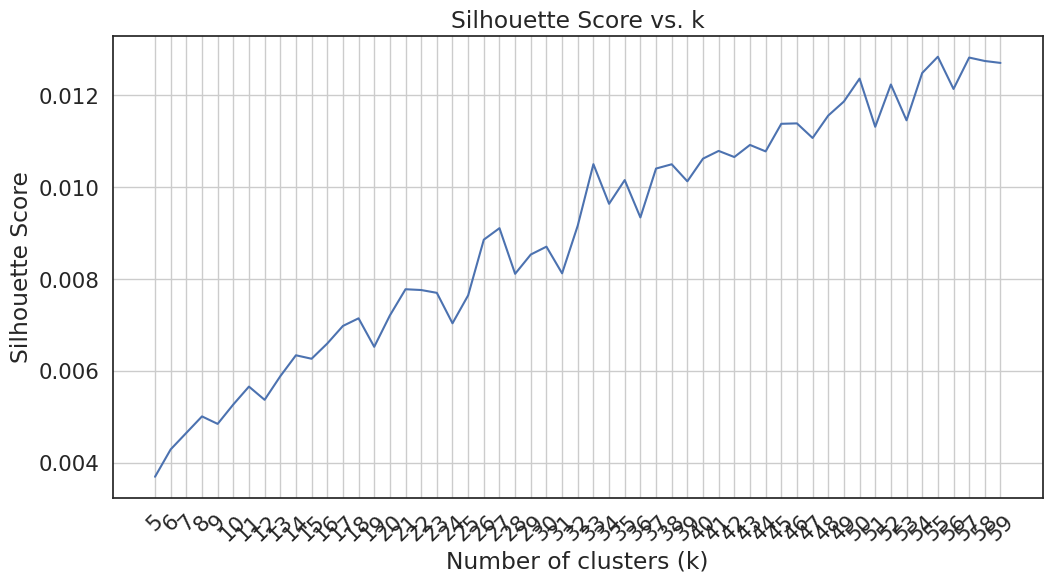

In [ ]:
# Plot for elbow method
plt.figure(figsize=(12, 6))
plt.plot(k_range, scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.xticks(k_range, rotation=45)
plt.grid(True)
plt.show()

Although the plot still doesn't show a clear elbow, using this new metric we can observe that we get only marginal improvements for $k>50$. We therefore choose $k=50$ as the optimal value for the number of clusters.

In [ ]:
from sklearn.cluster import KMeans

k = 50  # Replace with your chosen number of clusters
kmeans = KMeans(n_clusters=k, random_state=SEED, max_iter=100000, n_init=30)
kmeans.fit(X)

# Assign cluster labels to each document
df_tot['cluster'] = kmeans.labels_

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures")
print("-"*30)
print("Within-cluster sum-of-squares (Inertia):", kmeans.inertia_)
print("Silhouette coefficient:", metrics.silhouette_score(X, kmeans.labels_))

Intrinsic evaluation measures
------------------------------
Within-cluster sum-of-squares (Inertia): 10947.37438857789
Silhouette coefficient: 0.012361675198738743


By plotting the most relevant tokens for clusters we observe that docs relating to similar topics are brought together.

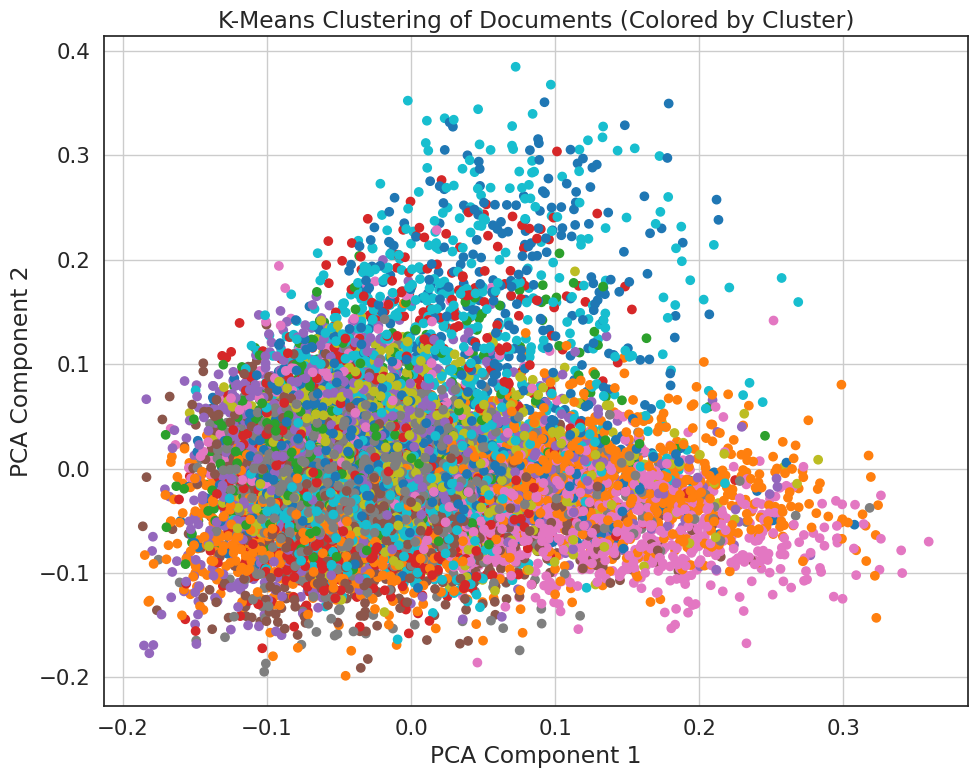

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to reduce TF-IDF vectors for 2D visualization
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())

# Assume you've already clustered the data with KMeans
labels = kmeans.labels_

# Plot using a built-in colormap
x_axis = scatter_plot_points[:, 0]
y_axis = scatter_plot_points[:, 1]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_axis, y_axis, c=labels, cmap='tab10')
plt.title("K-Means Clustering of Documents (Colored by Cluster)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Show the 10 most relevant tokens for a few clusters
for i in range(min(10, k)):
    print(f"Cluster {i}:")
    top_terms = [vocab[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_terms))
    print()

Cluster 0:
park, trail, river, lake, national, mountain, village, road, parks, trails

Cluster 1:
season, team, game, said, coach, year, players, games, nfl, play

Cluster 2:
story, series, characters, stories, character, beer, like, novel, episode, life

Cluster 3:
pm, 00, 11, 12, 2012, 10, 2010, 2015, posted, 06

Cluster 4:
health, care, patients, medical, patient, hospital, dental, services, treatment, healthcare

Cluster 5:
essay, writing, essays, thesis, paper, write, research, writers, students, help

Cluster 6:
just, like, got, time, know, really, think, ve, don, did

Cluster 7:
business, service, services, customer, customers, management, company, work, job, product

Cluster 8:
book, books, read, story, reading, author, writing, like, love, novel

Cluster 9:
skin, acne, oil, makeup, products, product, hair, natural, treatment, foundation



## Hierarchical Clustering
Given the difficulty of identifying a clear elbow (at least for reasonably low values of k) and the consequent difficulty in visualizing the docs clusters, we resort to hierarchical clustering using Ward's method as linkage method which aims at minimizing intra-cluster variance.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd

# For faster computation and plotting reduce this number (eg. 1000) to consider only a subset of docs
N_SAMPLES = X.shape[0]
X_subset = X[:N_SAMPLES]

# SVD reduction to make the tf-idf matrix more easily "tractable"
svd = TruncatedSVD(n_components=50, random_state=SEED)
X_reduced = svd.fit_transform(X_subset)

print(f"Reduced shape: {X_reduced.shape}")

# Compute pair-wise distances matrix
distance_matrix = ssd.pdist(X_reduced, metric='euclidean')

# Hierarchical clustering with 'ward' method
linkage_matrix = linkage(distance_matrix, method='ward')

Reduced shape: (11997, 50)


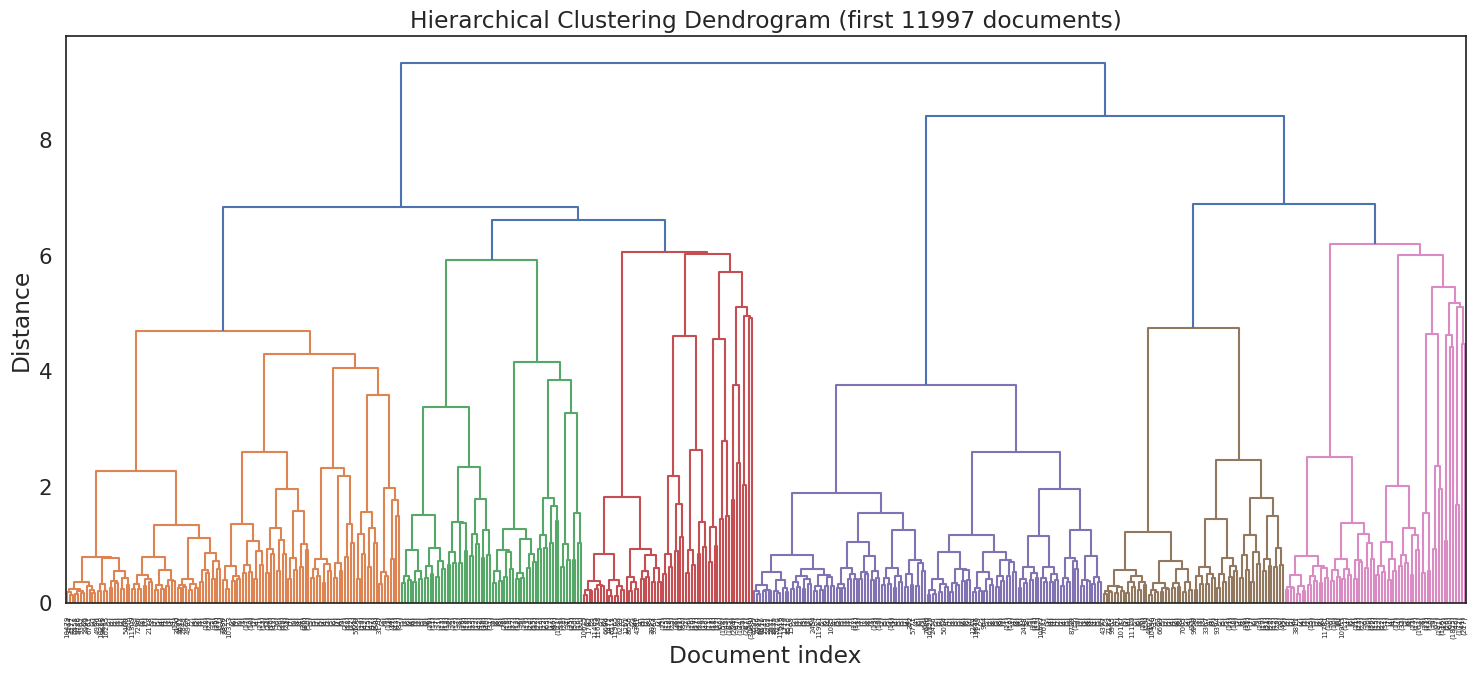

In [ ]:
# Dendogram plot
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=8)
plt.title(f"Hierarchical Clustering Dendrogram (first {N_SAMPLES} documents)")
plt.xlabel('Document index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

The dendogram allows us to identify 6 coarse macroclusters. We extract these macroclusters by cutting the dendogram horizontally such as to obtain at most 6 subtrees.

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendogram tree horizontally such as to form at most t flat macroclusters
cluster_labels = fcluster(linkage_matrix, t=6, criterion='maxclust')


[3 3 1 ... 2 1 3]


We now visualize the most relevant tokens for each macrocluster.

In [ ]:
for cluster_id in range(1, 7):  # fcluster gives cluster labels starting from 1
    # Get indices of documents in this macrocluster
    doc_indices = np.where(cluster_labels == cluster_id)

    # Compute mean tf-idf scores for all terms in this cluster
    cluster_tfidf = X[doc_indices].mean(axis=0).A1

    # Get top 10 terms
    top_term_indices = cluster_tfidf.argsort()[::-1][:10]
    top_terms = vocab[top_term_indices]

    print(f"\nTop terms in macrocluster {cluster_id}:")
    print(", ".join(top_terms))


Top terms in macrocluster 1:
business, data, company, software, use, service, information, marketing, windows, new

Top terms in macrocluster 2:
said, students, school, police, university, state, president, law, people, year

Top terms in macrocluster 3:
new, time, 10, year, use, people, water, like, health, car

Top terms in macrocluster 4:
game, season, games, team, play, league, said, players, win, points

Top terms in macrocluster 5:
food, recipe, cheese, chicken, wine, cup, add, restaurant, chocolate, eat

Top terms in macrocluster 6:
like, just, love, time, know, people, don, life, really, think


## Topic Modeling with LDA

In this section, we use **Latent Dirichlet Allocation (LDA)** to identify topics in our text data.
LDA assumes that each document is a mixture of topics and each topic is a distribution over words.
We will use `scikit-learn`'s implementation of LDA to extract latent topics from the corpus.



We begin by importing the LDA model and other utilities from `scikit-learn`.
We prepare a document-term matrix using `CountVectorizer` (with stop word removal and frequency thresholds) for LDA topic modeling.



In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizer instead of TF-IDF for LDA
count_vectorizer = CountVectorizer(max_df=0.8, min_df=5, stop_words='english', max_features=10000)
X_counts = count_vectorizer.fit_transform(doc_corpus)
terms = count_vectorizer.get_feature_names_out()

Set `n_topics`. Then initialize and fit an LDA model with custom alpha and beta priors to extract document-topic distributions from the count matrix.



In [ ]:
# Set the number of topics (eg. 10)
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=SEED,
    max_iter=100,
    doc_topic_prior=0.1,      # alpha
    topic_word_prior=0.01,    # beta
)

doc_topic_dist = lda.fit_transform(X_counts)

We extract the top terms for each topic by sorting the LDA component weights in descending order.


In [ ]:
# Extract top words for each topic
n_top_words = 10  # Set how many top words to extract
topics = []

for i, topic_weights in enumerate(lda.components_):
    top_terms_indices = topic_weights.argsort()[:-n_top_words - 1:-1]
    top_terms = [terms[i] for i in top_terms_indices]
    topics.append(top_terms)
    print(f"Topic {i}: {top_terms}")

Topic 0: ['like', 'just', 'time', 'don', 'love', 'know', 'good', 'people', 'really', 'think']
Topic 1: ['design', 'use', 'water', 'black', 'size', 'light', 'color', 'white', 'home', 'air']
Topic 2: ['business', 'company', 'market', 'new', 'money', 'year', 'companies', 'insurance', 'sales', 'said']
Topic 3: ['said', 'people', 'students', 'work', 'school', 'new', 'state', 'university', 'public', 'community']
Topic 4: ['crusher', 'price', 'machine', 'essay', 'china', 'equipment', 'plant', 'india', 'used', 'stone']
Topic 5: ['health', 'care', 'body', 'medical', 'use', 'treatment', 'help', 'skin', 'water', 'patients']
Topic 6: ['city', 'area', 'park', 'hotel', 'day', 'food', 'local', 'room', 'new', 'free']
Topic 7: ['use', 'online', 'data', 'information', 'free', 'using', 'time', 'new', 'site', 'web']
Topic 8: ['said', 'game', 'team', 'year', 'season', 'time', 'new', 'play', 'music', 'games']
Topic 9: ['10', '12', '11', 'pm', '15', '00', '13', '2012', '14', '30']


We evaluate the LDA model using perplexity and log-likelihood to assess its fit to the data.


In [ ]:
# 🔍 Perplexity
perplexity = lda.perplexity(X_counts)
print(f"Model perplexity: {perplexity:.2f}")

# 📈 Log-likelihood
log_likelihood = lda.score(X_counts)
print(f"Model log-likelihood: {log_likelihood:.2f}")


Model perplexity: 3337.62
Model log-likelihood: -24911222.29


We train an LDA model and compute a pseudo-cv coherence score by averaging word co-occurrences across top topic terms.


In [ ]:
from itertools import combinations

# Build binary term-document matrix
X_binary = (X_counts > 0).astype(int)

# Reverse index: word → index
term_index = {term: idx for idx, term in enumerate(terms)}

# Compute "pseudo-c_v" coherence
def topic_coherence(topic_words):
    indices = [term_index[word] for word in topic_words if word in term_index]
    if len(indices) < 2:
        return 0
    pair_scores = []
    for w1, w2 in combinations(indices, 2):
        docs_w1 = X_binary[:, w1]
        docs_w2 = X_binary[:, w2]
        co_occur = (docs_w1.multiply(docs_w2)).sum()
        pair_scores.append(co_occur)
    return np.mean(pair_scores) if pair_scores else 0

# Average coherence over all topics
coherences = [topic_coherence(t) for t in topics]
avg_coherence = np.mean(coherences)

print(f"Pseudo-cv coherence score (based on co-occurrence): {avg_coherence:.4f}")


Pseudo-cv coherence score (based on co-occurrence): 567.9156


### Compare results with different number of topics

We evaluate LDA models across different topic numbers using perplexity and log-likelihood, visualize the results, and print top words for the best model.


In [ ]:
# Define range of topics to test
k_values = range(5, 31, 5)
# Logging
perplexities = []
log_likelihoods = []
lda_models = []

print("Starting model evaluation...")
for k in k_values:
    lda = LatentDirichletAllocation(n_components=k, random_state=SEED, learning_method='batch')
    lda.fit(X_counts)

    perplexities.append(lda.perplexity(X_counts))
    log_likelihoods.append(lda.score(X_counts))
    lda_models.append(lda)

    print(f"k={k} → Perplexity: {perplexities[-1]:.2f}, LogLikelihood: {log_likelihoods[-1]:.2f}")

Starting model evaluation...
k=5 → Perplexity: 3670.51, LogLikelihood: -25203138.59
k=10 → Perplexity: 3347.26, LogLikelihood: -24920075.84
k=15 → Perplexity: 3213.85, LogLikelihood: -24795191.81
k=20 → Perplexity: 3100.58, LogLikelihood: -24685015.46
k=25 → Perplexity: 3063.25, LogLikelihood: -24647821.30
k=30 → Perplexity: 3057.39, LogLikelihood: -24641942.50
k=35 → Perplexity: 3030.15, LogLikelihood: -24614466.19


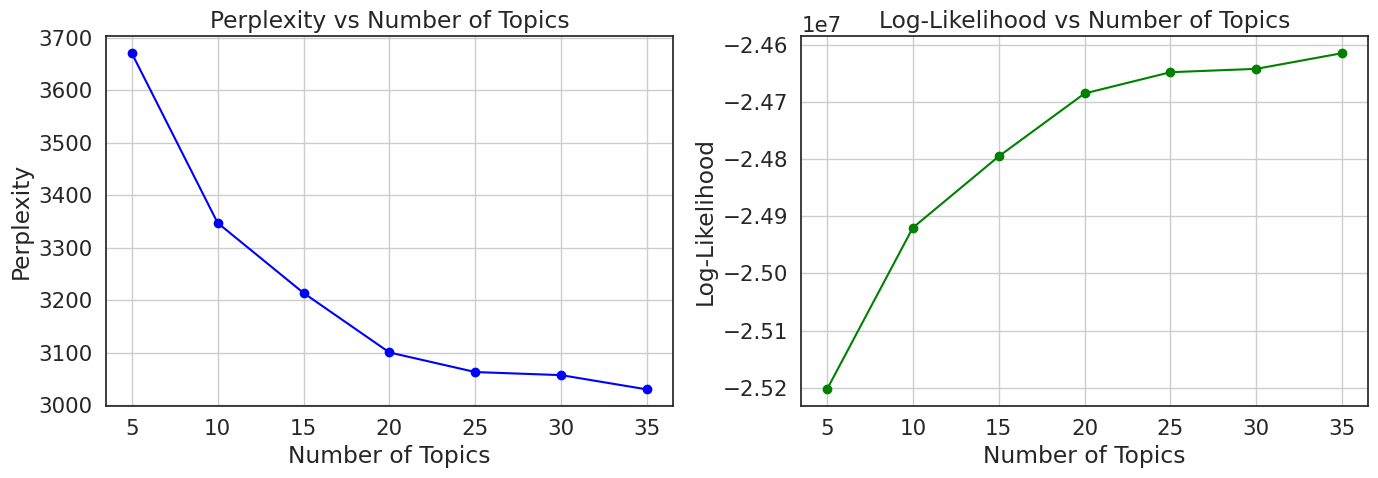

In [ ]:
# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, perplexities, marker='o', color='blue')
plt.title("Perplexity vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, log_likelihoods, marker='o', color='green')
plt.title("Log-Likelihood vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Log-Likelihood")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Select best model (with lowest perplexity)
best_index = np.argmin(perplexities)
best_k = k_values[best_index]
best_model = lda_models[best_index]

print(f"\nBest model: {best_k} topics (Perplexity: {perplexities[best_index]:.2f})")

n_top_words = 10
# Display top words for each topic
print("\nTop words for each topic:\n" + "-"*40)
for i, topic_weights in enumerate(best_model.components_):
    top_words_indices = topic_weights.argsort()[:-n_top_words-1:-1]
    top_words = [terms[idx] for idx in top_words_indices]
    print(f"Topic {i+1}: {', '.join(top_words)}")


Best model: 35 topics (Perplexity: 3030.15)

Top words for each topic:
----------------------------------------
Topic 1: just, don, like, time, people, know, make, need, want, way
Topic 2: room, home, property, hotel, rooms, free, bedroom, parking, storage, house
Topic 3: power, energy, air, new, high, gas, speed, engine, water, fuel
Topic 4: business, new, management, company, technology, data, marketing, work, services, development
Topic 5: book, writing, essay, books, read, sqft, lot, write, author, reading
Topic 6: body, skin, treatment, health, weight, use, cancer, blood, pain, disease
Topic 7: city, day, park, local, restaurant, event, hotel, area, visit, town
Topic 8: product, use, store, free, products, order, best, click, online, items
Topic 9: said, just, like, time, year, good, going, got, did, didn
Topic 10: said, police, news, new, report, according, says, vote, year, media
Topic 11: said, government, people, country, president, world, state, new, national, political
Topi

We define a function to compute topic coherence by measuring log co-occurrence ratios of word pairs across documents.


In [ ]:
from itertools import combinations
from collections import defaultdict
import numpy as np

def compute_topic_coherence(topics, documents, top_n=10):
    """
    Computes a simple coherence metric for each topic.
    - topics: list of topics (each is a list of words)
    - documents: list of documents (already tokenized)
    """
    # Build inverted index: word -> set of document indices
    word_doc_freq = defaultdict(set)
    for i, doc in enumerate(documents):
        for word in set(doc):
            word_doc_freq[word].add(i)

    topic_coherences = []
    for topic in topics:
        topic = topic[:top_n]
        pair_scores = []
        for w1, w2 in combinations(topic, 2):
            docs_w1 = word_doc_freq.get(w1, set())
            docs_w2 = word_doc_freq.get(w2, set())
            intersection = docs_w1 & docs_w2
            # Add 1 for smoothing
            score = (len(intersection) + 1) / (min(len(docs_w1), len(docs_w2)) + 1)
            pair_scores.append(np.log(score))
        if pair_scores:
            topic_coherences.append(np.mean(pair_scores))
        else:
            topic_coherences.append(0)

    return topic_coherences, np.mean(topic_coherences)


We tokenize documents, extract top topic words, compute topic coherence scores, and print both individual and average values.


In [ ]:
tokenized_docs = [doc.lower().split() for doc in doc_corpus]

n_top_words = 10
topics = [[terms[i] for i in topic.argsort()[:-n_top_words-1:-1]] for topic in lda.components_]
topic_scores, avg_score = compute_topic_coherence(topics, tokenized_docs)

for i, score in enumerate(topic_scores):
    print(f"Topic {i+1}: Coherence = {score:.4f}")
print(f"\n📊 Average topic coherence: {avg_score:.4f}")

Topic 1: Coherence = -0.6800
Topic 2: Coherence = -1.4783
Topic 3: Coherence = -1.5300
Topic 4: Coherence = -1.1759
Topic 5: Coherence = -1.6617
Topic 6: Coherence = -1.5908
Topic 7: Coherence = -1.6397
Topic 8: Coherence = -1.3912
Topic 9: Coherence = -0.7275
Topic 10: Coherence = -1.4248
Topic 11: Coherence = -1.0881
Topic 12: Coherence = -1.6295
Topic 13: Coherence = -2.9034
Topic 14: Coherence = -1.3939
Topic 15: Coherence = -0.7596
Topic 16: Coherence = -1.7321
Topic 17: Coherence = -1.3791
Topic 18: Coherence = -1.3455
Topic 19: Coherence = -1.8304
Topic 20: Coherence = -1.1437
Topic 21: Coherence = -0.6836
Topic 22: Coherence = -1.8037
Topic 23: Coherence = -1.3227
Topic 24: Coherence = -1.2522
Topic 25: Coherence = -1.7551
Topic 26: Coherence = -0.9467
Topic 27: Coherence = -2.1468
Topic 28: Coherence = -1.9494
Topic 29: Coherence = -2.0767
Topic 30: Coherence = -1.6977
Topic 31: Coherence = -2.3847
Topic 32: Coherence = -0.8959
Topic 33: Coherence = -1.5874
Topic 34: Coherence

## Indexing for keyWord searching

In [ ]:
!pip install -q python-terrier==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.7 MB/s eta 0:00:00


Now we prepare the training data for keyword indexing with PyTerrier by cleaning, reformatting, and assigning document IDs compatible with the retrieval engine.


In [ ]:
import pyterrier as pt
import pandas as pd

# Initialize PyTerrier
if not pt.started():
    pt.init()

# Use the training set
df = df_train.copy()

# Basic document preparation (no cleaning)
df = df.dropna(subset=["context"]).drop_duplicates(subset=["context"])
df = df[df["context"].str.strip().str.len() > 20]

# Rename columns for Terrier compatibility
df = df.reset_index(drop=True).reset_index()  # creates a numeric index
df = df.rename(columns={"index": "docno", "context": "text"})  # 'docno' and 'text' are expected



<ipython-input-19-d90d7e9a8a9d>:5: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


After indexing the documents with PyTerrier, we define a keyword-based search function using TF-IDF to retrieve and rank the most relevant contexts for a given query.


In [ ]:
df["docno"] = df["docno"].astype(str)


# Indexing the documents
indexer = pt.DFIndexer("./pt_index", overwrite=True)
index_ref = indexer.index(df["text"], df["docno"])
index = pt.IndexFactory.of(index_ref)

# Keyword Search Function

def search_keyword_pt(query, index, df, top_n=5):
    """
    Search for the top-N most relevant documents to a query using PyTerrier.
    """
    retriever = pt.BatchRetrieve(index, wmodel="TF_IDF")
    results = retriever.search(query).head(top_n)

    print(f"\nTop {top_n} documents most similar to the query '{query}':\n")
    for rank, row in enumerate(results.itertuples(), 1):
        doc_idx = int(row.docno)
        print(f"Rank {rank} - Document {doc_idx} - Score: {row.score:.4f}")
        print(df.loc[doc_idx, "text"][:300] + "...")
        print("-" * 80)

# Example Query

search_keyword_pt("artificial intelligence", index, df, top_n=3)

<ipython-input-21-a114d9e8f756>:5: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer = pt.DFIndexer("./pt_index", overwrite=True)


21:55:13.397 [main] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (1246) - further warnings are suppressed
21:55:26.665 [main] WARN org.terrier.structures.indexing.Indexer -- Indexed 13 empty documents

Top 3 documents most similar to the query 'artificial intelligence':

Rank 1 - Document 6423 - Score: 12.4801
Welcome To C&M Mining Machinery
The process of artificial sand making is complete. There are mainly three steps of crushing, washing and screening in the artificial sand making process. The crusherArtificialArtificialartificial sand manufacturing process in karnataka,,31/07/2013· artificial sand man...
--------------------------------------------------------------------------------
Rank 2 - Document 5779 - Score: 11.9201
Machine Learning is an application that comes under the hood of Artificial Intelligence. The primary aim of machine learning is to enable software applications to become exact and precise in forecasting the results. Under 

<ipython-input-21-a114d9e8f756>:15: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index, wmodel="TF_IDF")


# 2) Advanced Analysis

## BERTopic modeling

In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

We train a BERTopic model on the context documents corpus, view topic info and top words, and visualize the results interactively.


In [ ]:
from bertopic import BERTopic

# Create and train the model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(doc_corpus)

# General info about topics
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))  # first 10 topics

# Interactive visualization (only in Colab/Jupyter)
topic_model.visualize_topics()

# Show top words for each topic
for i in range(10):
    print(f"Topic {i}")
    print(topic_model.get_topic(i))
    print("-" * 40)


2025-05-25 13:49:12,382 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/375 [00:00<?, ?it/s]

2025-05-25 13:50:10,691 - BERTopic - Embedding - Completed ✓
2025-05-25 13:50:10,695 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-25 13:50:49,858 - BERTopic - Dimensionality - Completed ✓
2025-05-25 13:50:49,860 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-25 13:50:58,154 - BERTopic - Cluster - Completed ✓
2025-05-25 13:50:58,181 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-25 13:51:04,904 - BERTopic - Representation - Completed ✓


   Topic  Count                          Name  \
0     -1   5219              -1_the_and_to_of   
1      0    235      0_weight_body_diet_blood   
2      1    234  1_trading_forex_market_stock   
3      2    218         2_god_jesus_church_we   
4      3    186  3_marketing_your_you_content   
5      4    179          4_film_movie_his_the   
6      5    178              5_my_you_me_that   
7      6    169       6_album_song_music_band   
8      7    166      7_love_christmas_card_my   
9      8    162   8_water_climate_energy_coal   

                                      Representation  \
0    [the, and, to, of, in, is, for, that, on, with]   
1  [weight, body, diet, blood, of, health, is, yo...   
2  [trading, forex, market, stock, shares, bank, ...   
3  [god, jesus, church, we, christ, lord, his, of...   
4  [marketing, your, you, content, web, media, bu...   
5   [film, movie, his, the, he, is, as, of, was, it]   
6  [my, you, me, that, your, life, what, to, it, we]   
7  [album, s

We compute the Silhouette Score for BERTopic by embedding non-outlier documents and measuring clustering quality.


In [ ]:
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import numpy as np

# 1. Remove documents assigned to topic -1 (outliers)
valid_indices = [i for i, t in enumerate(topics) if t != -1]
filtered_docs = [doc_corpus[i] for i in valid_indices]
filtered_labels = [topics[i] for i in valid_indices]

# 2. Create document embeddings (with the same model used by BERTopic)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # same default as BERTopic
doc_embeddings = embedding_model.encode(filtered_docs, show_progress_bar=True)

# 3. Compute the Silhouette Score
score = silhouette_score(doc_embeddings, filtered_labels)
print(f"📊 Silhouette Score (BERTopic): {score:.4f}")



Batches:   0%|          | 0/212 [00:00<?, ?it/s]

📊 Silhouette Score (BERTopic): 0.0313


## Bidirectional LSTM question classifier
We aim to analyse the types of questions in the dataset. Since such questions are not labelled we first train a question classifier on the TREC dataset and use it to classify the RAG 12000 questions. The Text REtrieval Conference (TREC) Question Classification dataset contains 5500 labeled questions in training set and another 500 for test set.
Each question is labelled into one of 6 categories:
0. 'ABBR': Abbreviation.
1. 'ENTY': Entity.
2. 'DESC': Description and abstract concept.
3. 'HUM': Human being.
4. 'LOC': Location.
5. 'NUM': Numeric value.

In [ ]:
from datasets import load_dataset, concatenate_datasets

dataset_trec = load_dataset("trec", trust_remote_code=True)

print(dataset_trec)

train_set_trec = dataset_trec["train"] # Train split (5500 examples)
test_set_trec = dataset_trec["test"] # Test split (500 examples)

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

trec.py:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})


Clean the TREC dataset by removing examples where any field is empty or just whitespace from both train set and test set.

In [ ]:
print(f"Original size train: {len(train_set_trec)}")
train_set_trec = train_set_trec.filter(lambda example: bool(example["text"] is not None and example["text"].strip()))
train_set_trec = train_set_trec.filter(lambda example: bool(example["coarse_label"] is not None))
print(f"Size train after removing NaNs: {len(train_set_trec)}\n")

print(f"Original size test: {len(test_set_trec)}")
test_set_trec = test_set_trec.filter(lambda example: bool(example["text"] is not None and example["text"].strip()))
test_set_trec = test_set_trec.filter(lambda example: bool(example["coarse_label"] is not None))
print(f"Size test after removing NaNs: {len(test_set_trec)}\n")

full_set_trec = concatenate_datasets([train_set_trec, test_set_trec])

Original size train: 5452


Filter:   0%|          | 0/5452 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5452 [00:00<?, ? examples/s]

Size train after removing NaNs: 5452

Original size test: 500


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Size test after removing NaNs: 500



In [ ]:
train_x = train_set_trec["text"]
train_y = train_set_trec["coarse_label"]

test_x = test_set_trec["text"]
test_y = test_set_trec["coarse_label"]

Build training and validation Tensorflow datasets. Visualize the first training batch.

In [ ]:
import tensorflow as tf

train_tf = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_tf = tf.data.Dataset.from_tensor_slices((test_x, test_y))

train_dataset = train_tf.shuffle(buffer_size=10000).batch(batch_size=16).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_tf.batch(batch_size=16).prefetch(tf.data.AUTOTUNE)

for batch in train_dataset.take(1):
  print(batch)

(<tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'What causes the redness in your cheeks when you blush ?',
       b"Why is the universe flat , if it started by an explosion , shouldn 't it be a sphere ?",
       b'Where is Tornado Alley ?',
       b'When did the supercontinent Pangaea break up ?',
       b"What beer 's name is translated as `` lion brew '' ?",
       b'Who was the prophet of the Jewish people ?',
       b'When did Mount St. Helen last have a major eruption ?',
       b"What is Dr. Ruth 's last name ?",
       b"What U.S. Congressman said : `` Keep the faith , baby '' .",
       b'Who was the first X-Man to die in battle ?',
       b'What department store heir is responsible for raising a three-ton safe from the underwater wreckage of the Andrea Doria ?',
       b'How do you stop junk snail mail ?',
       b'What computer operating system is on the most computers ?',
       b'Where does chocolate come from ?',
       b'CPR is the abbreviation for what ?',
       

Build the vectorizer.

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=10000)
# train_text = train_dataset.map(lambda text, label: text).unbatch()
vectorizer.adapt(train_x)

vocab = vectorizer.get_vocabulary()

Show vocabulary information and some sample question vectorizations.

In [ ]:
print(f"Vocab length: {len(vocab)}")
print(f"First 100 tokens: {vocab[:100]}")

for text in batch[0][:6].numpy():
    encoding = vectorizer([text]).numpy()[0]
    print('Question:     ', text.decode("utf-8"))
    print('Encoded:   ', encoding)
    print('Recovered: ',' '.join([vocab[i] for i in encoding]))
    print()

Vocab length: 8604
First 100 tokens: ['', '[UNK]', np.str_('the'), np.str_('what'), np.str_('is'), np.str_('of'), np.str_('in'), np.str_('a'), np.str_('how'), np.str_('s'), np.str_('was'), np.str_('who'), np.str_('to'), np.str_('for'), np.str_('are'), np.str_('and'), np.str_('does'), np.str_('did'), np.str_('do'), np.str_('many'), np.str_('name'), np.str_('on'), np.str_('where'), np.str_('i'), np.str_('first'), np.str_('you'), np.str_('can'), np.str_('when'), np.str_('world'), np.str_('us'), np.str_('from'), np.str_('which'), np.str_('that'), np.str_('by'), np.str_('country'), np.str_('most'), np.str_('an'), np.str_('with'), np.str_('as'), np.str_('have'), np.str_('city'), np.str_('has'), np.str_('why'), np.str_('it'), np.str_('there'), np.str_('be'), np.str_('people'), np.str_('get'), np.str_('were'), np.str_('at'), np.str_('find'), np.str_('called'), np.str_('his'), np.str_('state'), np.str_('year'), np.str_('president'), np.str_('american'), np.str_('war'), np.str_('mean'), np.str_(

Define the network architecture:
- Bidirectional LSTM with embedding size of 64.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
import tensorflow as tf

num_classes = train_set_trec.features["coarse_label"].num_classes

model = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │       550,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625,350 (2.39 MB)

 Trainable params: 625,350 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

Train the model.

In [ ]:
model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2797 - loss: 1.7459 - val_accuracy: 0.3940 - val_loss: 1.5829
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4738 - loss: 1.3899 - val_accuracy: 0.5160 - val_loss: 1.1821
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6969 - loss: 0.9347 - val_accuracy: 0.7400 - val_loss: 0.9284
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8015 - loss: 0.6688 - val_accuracy: 0.7960 - val_loss: 0.7794
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8835 - loss: 0.4479 - val_accuracy: 0.7940 - val_loss: 0.6948
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9229 - loss: 0.3430 - val_accuracy: 0.8280 - val_loss: 0.6262
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9452 - loss: 0.2377 - val_accuracy: 0.8120 - val_loss: 0.6027
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9555 - loss: 0.1802 - val_accura

Evaluate the model.

In [ ]:
loss, accuracy = model.evaluate(valid_dataset)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8387 - loss: 0.5969
Test loss: 0.5606
Test accuracy: 0.8500


Plot confusion matrix.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


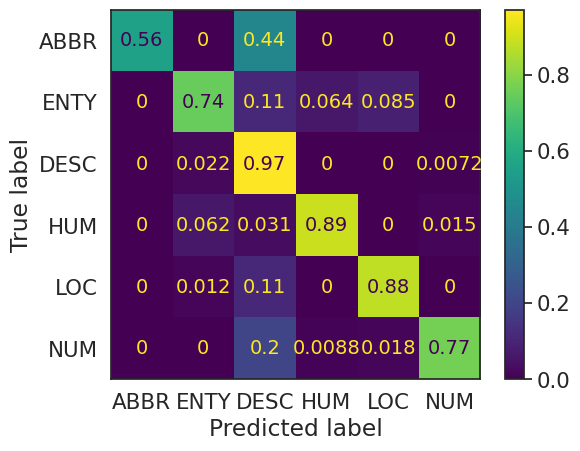

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

trec_labels = ["ABBR", "ENTY", "DESC", "HUM", "LOC", "NUM"]

true_coarse = test_y
pred_coarse = np.argmax(model.predict(valid_dataset), axis=1)

cmd = ConfusionMatrixDisplay(confusion_matrix(true_coarse, pred_coarse, normalize='true'), display_labels=trec_labels)
cmd.plot()

We observe poor performance on ABBR type questions. We attribute this to the underrepresentation of such type of questions in both the training and testing set.

In [ ]:
from collections import Counter

# Count labels in trec train set
train_counts = Counter(example["coarse_label"] for example in train_set_trec)
test_counts = Counter(example["coarse_label"] for example in test_set_trec)

# Display counts for labels 0 to 5
for label in range(num_classes):
    print(f"Label {label} - Train: {train_counts[label]}, Test: {test_counts[label]}")

Label 0 - Train: 86, Test: 9
Label 1 - Train: 1250, Test: 94
Label 2 - Train: 1162, Test: 138
Label 3 - Train: 1223, Test: 65
Label 4 - Train: 835, Test: 81
Label 5 - Train: 896, Test: 113


Finally we can apply the model to analyse the questions in the RAG 12000 dataset.

In [ ]:
questions = full_set["question"]

# Convert to a NumPy array or TensorFlow tensor
questions_tensor = tf.convert_to_tensor(questions, dtype=tf.string)

logits = model.predict(questions_tensor)
preds = np.argmax(logits, axis=1)
predicted_labels = [trec_labels[i] for i in preds]

# Add a column with the question type to the full df
df_tot["question_type"] = predicted_labels

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,context,question,answer,question_type
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...,ENTY
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...,DESC
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...,DESC
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...,DESC
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...,DESC


Visualize an example for each question type.

In [ ]:
df_tot[["question", "question_type"]].groupby("question_type", group_keys=False).sample(n=1, random_state=SEED)

,question,question_type
5330,"What does the acronym ""WSIPI"" stand for?",ABBR
6289,How can you use the Photomerge feature in Phot...,DESC
4772,What advice does the North Wales Chronicle's f...,ENTY
2632,Who presented Sean “Diddy” Combs with the keys...,HUM
10015,Where did Douglas receive his BA in Political ...,LOC
26,When was the new village hall opened after a 1...,NUM


Plot question type distribution.

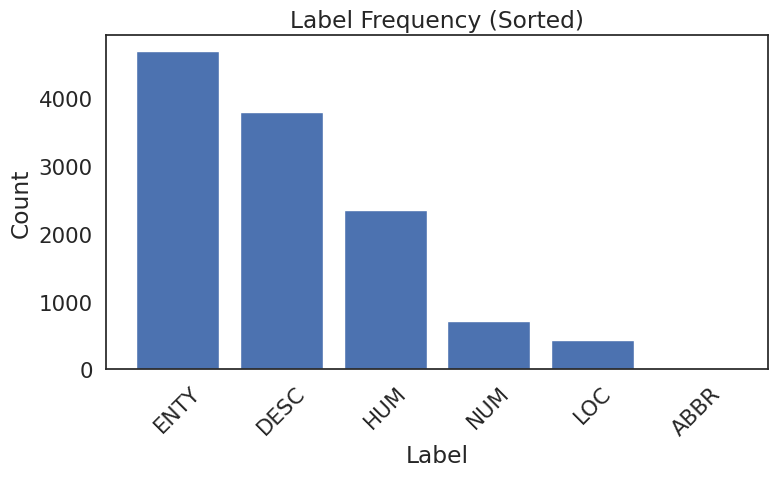

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the labels
label_counts = Counter(predicted_labels)

# Sort labels by count in descending order
sorted_labels_counts = label_counts.most_common()
labels, counts = zip(*sorted_labels_counts)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Frequency (Sorted)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Semantic Search

### Load sentence embedding model
We create an instance of a sentence embedding model based on BERT.

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

semb_model = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Use it to pre-compute the context documents corpus embeddings.

In [ ]:
docs_embeddings = semb_model.encode(doc_corpus, convert_to_tensor=True, device='cuda')

Test retrieval of documents from the corpus given a query. Cosine similarity between query and document is used as distance metric.

In [ ]:
queries = [
    'A man is eating pasta.',
    'Someone in a gorilla costume is playing a set of drums.',
    'A cheetah chases prey on across a field.'
]

k = 1
# Set the maximum number of matches to retrieve
top_k = min(k, len(doc_corpus))

# Iterate over queries
for query in queries:
    # Embed query
    query_embedding = semb_model.encode(query, convert_to_tensor=True)
    # Use cosine-similarity and torch.topk to find the closest document in embedding space
    cos_scores = util.cos_sim(query_embedding, docs_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    # Print the result
    print(f"Query: \"{query}\"")
    print(f"Score: {score:.2f}")
    print("---------------------------------------")
    for score, idx in zip(top_results[0], top_results[1]):
        print(f"{doc_corpus[idx]}\n")
    print("\n\n")

Query: "A man is eating pasta."
Score: 0.35
---------------------------------------
Ronzoni Spaghetti, 100% Whole Grain
Popular near you
Related Products
Details
100% whole wheat. Excellent source of fiber. 56 g whole grains per serving. All natural. When it comes to nutrition, why settle for less than 100%? Ronzoni Healthy Harvest pasta is 100% all natural and made from a single ingredient, 100% whole wheat. With an excellent source of fiber and 56 g of whole grains per serving, it is an important part of a heart healthy (Diets rich in whole grain foods and other plant foods and low in total fat, saturated fat, and cholesterol may reduce the risk of heart disease and some cancers. While many factors affect heart disease, diets low in saturated fat and cholesterol may reduce the risk of this disease) diet. Its delicious flavor is the perfect complement to your favorite pasta recipes. When it comes to keeping your family happy and eating healthy why settle for less than 100%?.
Ingredien

## Load cross-encoder model
We create an instance of a cross-encoder model based on BERT.

In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util

xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

Test retrieval of documents from the corpus given a query. Using a cross-encoder generally leads to more accurate retrieval than the previous method based on cosine similarity alone. But it is also considerably slower since we cannot exploit the pre-computed documents embeddings.

In [ ]:
queries = [
    'A man is eating pasta.',
    'Someone in a gorilla costume is playing a set of drums.',
    'A cheetah chases prey on across a field.'
]

k = 1
# Set the maximum number of matches to retrieve
top_k = min(k, len(doc_corpus))

# Iterate over queries
for query in queries:
    # Prepare model inputs
    model_inputs = [[query, doc] for doc in doc_corpus]
    # Predict similarity score
    scores = xenc_model.predict(model_inputs)
    # Print the result
    print(f"Query: \"{query}\"")
    print("---------------------------------------")
    for idx in np.argsort(-scores)[0:top_k]:
        print(f"Score: {scores[idx]:.4f} - Document: \"{doc_corpus[idx]}\"")
    print("\n\n\n\n")

## Retrieve and rerank
In order to avoid having to compute the embedding of each $(query, document)$ pair we can use a hybrid approach.

We first perform fast retrival of the top $k$ most similar documents by cosine similarity.

In [ ]:
query = "What is the Berry Export Summary 2028 and what is its purpose?"

k = 100
top_k = min(k, len(doc_corpus))

# Embed query with sentence embdding modeel
query_embedding = semb_model.encode(query, convert_to_tensor=True)
# Use cosine-similarity and torch.topk to find the highest top_k similarity scores
cos_scores = util.cos_sim(query_embedding, docs_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)
# print(top_results[0], top_results[1])

We then use the cross-encoder to rerank them by relevance wrt the query.

In [ ]:
doc_idxs = top_results[1].tolist()
# Consider only the documents identified in the previous step
model_inputs = [[query, doc_corpus[idx]] for idx in doc_idxs]

# Predict relevance scores with cross-encoder model
cross_scores = xenc_model.predict(model_inputs)

Finally we take the resulting most relevant documents (after reranking).

In [ ]:
print("Cross-encoder model re-ranking results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
# Take top 3 of the reranked documents
for idx in np.argsort(-cross_scores)[:3]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{model_inputs[idx]}\"\n\n")

We create a class implementing such Retrieve&Rerank strategy for later use.

Even though our corpus only consists of 12000 documents the class will make use of a FAISS index. This way it can scale and be used as a retriever even for larger corpuses.

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 24.6 MB/s eta 0:00:00


In [ ]:
import faiss
import torch
import numpy as np
from sentence_transformers import util

class DocRetrieveRerank:
    def __init__(self, docs, semb_model, xenc_model, device='cpu'):
        self.docs = docs
        self.semb_model = semb_model
        self.xenc_model = xenc_model
        self.device = device

        self.n_docs = len(docs)
        # Precompute embeddings and convert to numpy
        self.docs_embeddings = semb_model.encode(docs, convert_to_numpy=True, normalize_embeddings=True, device=self.device)

        # Build FAISS index (inner product == cosine similarity on normalized vectors)
        self.index = faiss.IndexFlatIP(self.docs_embeddings.shape[1])
        self.index.add(self.docs_embeddings)

    """
    Retrieves and reranks documents for a given query.

    Args:
        query (str): The input query.
        k (int): Number of top documents to return.

    Returns:
        most_rel_docs (List[str]): Top-k reranked documents.
        most_rel_doc_idxs (List[int]): Indices in original doc list.
    """
    def retrieve(self, query, k=1):
        k_semb = min(50 * k, self.n_docs)
        k_xenc = min(k, self.n_docs)

        # Encode and normalize query embedding obtaining a (embedding_size) vector
        query_embedding = self.semb_model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
        # Since FAISS expects a (num_queries, embedding_size) matrix
        query_embedding = query_embedding.reshape(1, -1)

        # Search top-k in FAISS
        cos_scores, doc_idxs = self.index.search(query_embedding, k_semb)
        # Since FAISS returns a (num_queries, k) matrix
        doc_idxs = doc_idxs[0]

        # Prepare cross-encoder inputs
        xenc_inputs = [[query, self.docs[idx]] for idx in doc_idxs]
        cross_scores = self.xenc_model.predict(xenc_inputs)

        # These idxs refer to xenc_inputs (not self.docs)
        most_rel_idxs = np.argsort(-cross_scores)[:k_xenc]
        most_rel_docs = [xenc_inputs[idx][1] for idx in most_rel_idxs]
        # Map the idxs to the original document corpus
        most_rel_doc_idxs = [doc_idxs[idx] for idx in most_rel_idxs]

        return most_rel_docs, most_rel_doc_idxs


# 4) BERT Models Fine-Tuning

The task we aim to solve here is understanding if the answer to a question is contained in a given context document. To solve this task we make use of both the RAG 12000 dataset and the RAG hallucination dataset. The latter contains $(question, context)$ pairs for which the answer cannot be answered from the context. We fine-tune a BERT based classifier to solve this task.


We load the RAG hallucination dataset.

In [ ]:
# Data loading
hallucination_dataset = load_dataset("neural-bridge/rag-hallucination-dataset-1000")

hall_train_set = hallucination_dataset["train"]
hall_test_set = hallucination_dataset["test"]

Clean the data by removing rows with empty entries.

In [ ]:
# Data cleaning
hall_train_set = hall_train_set.filter(lambda example: bool(example["context"] is not None and example["context"].strip()))
hall_train_set = hall_train_set.filter(lambda example: bool(example["question"] is not None and example["question"].strip()))
hall_train_set = hall_train_set.filter(lambda example: bool(example["answer"] is not None and example["answer"].strip()))

hall_test_set = hall_test_set.filter(lambda example: bool(example["context"] is not None and example["context"].strip()))
hall_test_set = hall_test_set.filter(lambda example: bool(example["question"] is not None and example["question"].strip()))
hall_test_set = hall_test_set.filter(lambda example: bool(example["answer"] is not None and example["answer"].strip()))

Convert it to dataframes. Introduce **answerable** column assigning label 1 to RAG 12000 answers and label 0 to hallucinated answers in the train and test sets.


In [ ]:
# Convert to pandas df
hall_df_train = hall_train_set.to_pandas()
hall_df_test = hall_test_set.to_pandas()

# RAG 12000
df_train['labels'] = 1
df_test['labels'] = 1

# RAG hallucination
hall_df_train['labels'] = 0
hall_df_test['labels'] = 0



We create balanced and shuffled train and evaluation datasets by combining real and hallucinated samples.

The RAG hallucination dataset only contains 800 samples in the train split so we have to sample an equivalent number of samples from the RAG 12000 dataset in order to get a balanced training set.



In [ ]:
# Create mixed dataframe by concatenation
train_dataset = pd.concat([df_train.sample(n=800, random_state=SEED), hall_df_train], ignore_index=True)
eval_dataset = pd.concat([df_test.sample(n=200, random_state=SEED), hall_df_test], ignore_index=True)

# Shuffle
train_dataset = train_dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
eval_dataset = eval_dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)

We display a random sample of 20 training examples and check the total size of the training dataset.


In [ ]:
train_dataset.sample(n=10, random_state = SEED)

,context,question,answer,answerable,labels
526,Is Lip Gloss make From Whale Sperm?A lot of pe...,What is the main ingredient in Glossier lip gl...,This question cannot be answered.,NaN,0
354,Training Videos (HeinOnline) Search For Home T...,What is the purpose of the Congressional Recor...,This question cannot be answered.,NaN,0
168,Pikolo Apartments - Green studio\nFrom $39 / n...,How many people can the Pikolo Apartments - Gr...,The Pikolo Apartments - Green studio can accom...,1.0,1
135,Digestive system disorder case studies\nDigest...,What are some of the services mentioned in the...,The services mentioned in the context that can...,1.0,1
937,Long Beach Needs This: City-Owned Big Lots for...,"What is the ""fine-grained urbanism"" concept pr...","""Fine-grained urbanism"" is a concept proposed ...",1.0,1
1544,"""The Nutcracker"" has been enchanting audiences...","How many performances of ""The Nutcracker"" does...",The Royal Winnipeg Ballet gives 20 performance...,1.0,1
1253,"By Lynette Nyman, Red Cross Staff, Twin Cities...",What is the name of the church that provided s...,This question cannot be answered.,NaN,0
237,TAMPA — Myriam Escobar began getting annual ma...,What is the name of the breast cancer educatio...,This question cannot be answered.,NaN,0
478,When I began teaching in the late 1980's in a ...,What are the two most desired qualities the bu...,"Creativity, and critical thinking are the two ...",1.0,1
650,Pam has written an article which has appeared ...,What is the process of creating a banknote acc...,The process of creating a banknote includes Id...,1.0,1


We convert the train and evaluation DataFrames to Hugging Face datasets.


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_dataset)
eval_dataset = Dataset.from_pandas(eval_dataset)

We tokenize the context-question pairs with BERT, apply padding/truncation, and format the datasets for PyTorch training and evaluation.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(
        example["context"],
        example["question"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset = train_dataset.map(tokenize, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

eval_dataset = eval_dataset.map(tokenize, batched=True)
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
!pip install transformers
!pip install torch torchvision

We load a BERT model for binary sequence classification using the `bert-base-uncased` checkpoint.


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After model training, this function enables evaluation by calculating accuracy, precision, recall, and F1 score based on predictions and labels.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
!pip install transformers --upgrade
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


To prepare for training, we configure key settings such as batch size, evaluation frequency, learning rate, and checkpointing strategy.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert-finetune-results",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,

    eval_strategy="steps",   # Enable evaluation during training
    save_strategy="steps",         # Save models during training
    eval_steps=400,                # Evaluate every 400 steps (~half an epoch)
    save_steps=400,                # Save every 400 steps
    load_best_model_at_end=True,  # Restore best checkpoint (requires evaluation_strategy)
    metric_for_best_model="accuracy",

    save_total_limit=2,
    seed=SEED,
    fp16=True,                     # Use if GPU supports it (speeds up training)
    do_eval=True,
    do_train=True,
)

At this stage, we initialize the Trainer with the model, datasets, metrics, and early stopping, then start fine-tuning.


In [ ]:
from transformers import Trainer, EarlyStoppingCallback

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,     # Define separately
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: michaelgear12 (michaelgear12-politecnico-di-milano) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
400,0.595900,0.643569,0.647500,0.621413,0.703624,0.647500
800,0.563800,0.605630,0.765000,0.761270,0.782667,0.765000
1200,0.361000,0.987039,0.775000,0.772492,0.787687,0.775000
1600,0.409100,0.969430,0.782500,0.782106,0.784556,0.782500
2000,0.200500,1.266970,0.790000,0.789979,0.790116,0.790000
2400,0.125400,1.229540,0.795000,0.794995,0.795030,0.795000
2800,0.082200,1.481764,0.790000,0.789953,0.790261,0.790000
3200,0.039200,1.743421,0.765000,0.763843,0.770298,0.765000
3600,0.046000,1.703454,0.777500,0.777432,0.777840,0.777500


TrainOutput(global_step=3600, training_loss=0.2735245911859804, metrics={'train_runtime': 875.1078, 'train_samples_per_second': 18.283, 'train_steps_per_second': 4.571, 'total_flos': 3788799197184000.0, 'train_loss': 0.2735245911859804, 'epoch': 9.0})

Once training is complete, we evaluate the model on the validation set and print the resulting metrics.


In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 1.2295403480529785, 'eval_accuracy': 0.795, 'eval_f1': 0.7949948748718718, 'eval_precision': 0.7950295029502951, 'eval_recall': 0.795, 'eval_runtime': 2.9089, 'eval_samples_per_second': 137.507, 'eval_steps_per_second': 17.188, 'epoch': 9.0}


To perform inference, we move the model to the appropriate device and define a function that classifies a question-context pair as answerable or not.


In [ ]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device (do this once after loading the model)
model.to(device)

def classify_question(context, question):
    # Tokenize and move input tensors to the same device
    inputs = tokenizer(context, question, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run model in inference mode (no gradients)
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = outputs.logits.argmax(dim=1).item()

    return "Answerable" if prediction == 1 else "Unanswerable"

A set of labeled test cases is defined to evaluate the model’s ability to distinguish between answerable and unanswerable questions based on given contexts.


In [ ]:
test_cases = [
    # Answerable
    ("The Pacific Ocean is the largest and deepest of Earth's oceanic divisions.", "What is the largest ocean on Earth?", "Answerable"),
    ("Einstein developed the theory of relativity in the early 20th century.", "Who developed the theory of relativity?", "Answerable"),
    ("Mount Everest is the highest mountain in the world above sea level.", "What is the tallest mountain in the world?", "Answerable"),
        ("The Amazon rainforest is located in South America and is the largest tropical rainforest in the world.",
     "Where is the Amazon rainforest located?",
     "Answerable"),
    ("The Great Wall of China was built over several centuries to protect Chinese states against invasions.",
     "Why was the Great Wall of China built?",
     "Answerable"),
    ("The water cycle involves processes like evaporation, condensation, and precipitation.",
     "What are the main processes in the water cycle?",
     "Answerable"),
    ("Mars is the fourth planet from the Sun and is often called the Red Planet.",
     "Which planet is known as the Red Planet?",
     "Answerable"),
    ("Photosynthesis is the process by which green plants use sunlight to synthesize food from carbon dioxide and water.",
     "What is the process by which plants make food using sunlight?",
     "Answerable"),
    # Unanswerable
    ("The Pacific Ocean is the largest and deepest of Earth's oceanic divisions.", "What is the capital of Germany?", "Unanswerable"),
    ("The iPhone 13 was released in September 2021.", "What is the tallest building in Dubai?", "Unanswerable"),
    ("Shakespeare wrote many plays including Macbeth and Hamlet.", "How far is the moon from Earth?", "Unanswerable"),
    ("The human heart has four chambers: two atria and two ventricles.",
     "What is the capital of Canada?",
     "Unanswerable"),
    ("The Mona Lisa is a famous painting created by Leonardo da Vinci.",
     "When was the Eiffel Tower constructed?",
     "Unanswerable"),
    ("George Washington was the first President of the United States.",
     "What is the boiling point of mercury?",
     "Unanswerable"),
    ("Lightning is a sudden electrostatic discharge during a storm.",
     "Who is the CEO of Google?",
     "Unanswerable"),
    ("The Titanic sank in the North Atlantic Ocean in 1912 after hitting an iceberg.",
     "How many bones are in the human body?",
     "Unanswerable"),
]

To evaluate model performance, we generate predicted labels on the evaluation set, then visualize the results using a confusion matrix.


In [ ]:
eval_dataset.column_names  # View all columns

['context',
 'question',
 'answer',
 'labels',
 'input_ids',
 'token_type_ids',
 'attention_mask']

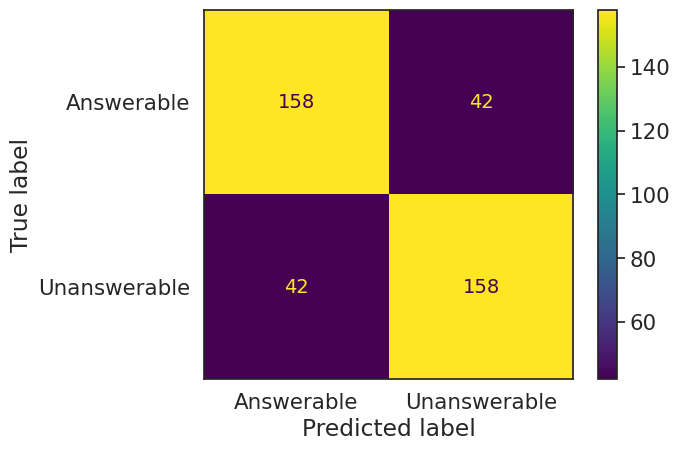

In [ ]:
# args (context, question)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

eval_zipped = zip(eval_dataset["context"], eval_dataset["question"], eval_dataset["labels"])


# Extract true labels
true_labels = ["Answerable" if label == 1 else "Unanswerable" for _, _, label in eval_zipped]
predicted_labels = []

eval_zipped = zip(eval_dataset["context"], eval_dataset["question"], eval_dataset["answerable"])
# Loop through each test case and print the result
for context, question, expected in eval_zipped:
    result = classify_question(context, question)
    #print(f"Context: {context}")
    #print(f"Question: {question}")
    #print(f"Expected Output: {expected}")
    #print(f"Model Output: {result}")
    #print("-" * 50)
    predicted_labels.append(result)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["Answerable", "Unanswerable"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Answerable", "Unanswerable"])
disp.plot()
plt.show()


# 5) LLM

In this section we load a quantized large language model (`Mistral-7B GPTQ`) and uses it to classify whether a question is answerable based on a given context. It:



1.   Loads the tokenizer and model (`AutoGPTQForCausalLM`) from HuggingFace.
2.   Builds prompts with optional reasoning examples (few-shot learning).
1.   Uses the model to generate answers and classifies the result as Answerable or Unanswerable.
1.   Evaluates performance on a set of test cases using zero-shot, one-shot, and few-shot strategies.
2.   Calculates and prints accuracy and a result table.






In [ ]:
!pip install ninja
!pip uninstall -y auto-gptq
!git clone https://github.com/PanQiWei/AutoGPTQ.git
%cd AutoGPTQ
!BUILD_CUDA_EXT=1 python setup.py install
!pip install gekko
!pip install -U datasets


!pip install -U transformers optimum auto-gptq

!pip uninstall -y optimum auto-gptq

!pip install git+https://github.com/huggingface/optimum.git@main
!pip install auto-gptq

!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 6.4 MB/s eta 0:00:00
Cloning into 'AutoGPTQ'...
remote: Enumerating objects: 5016, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 5016 (delta 39), reused 15 (delta 15), pack-reused 4957 (from 5)
Receiving objects: 100% (5016/5016), 8.23 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (3286/3286), done.
/content/AutoGPTQ

GPTQModel has been merged into Transformers/Optimum and full deprecation of AutoGPTQ within HF frameworks is planned in the near-future.

conda_cuda_include_dir /usr/lib/python3.11/site-packages/nvidia/cuda_runtime/include
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build,

In [ ]:
# !pip install auto-gptq datasets transformers

from transformers import AutoTokenizer
from auto_gptq import AutoGPTQForCausalLM
import torch
import pandas as pd
import re


model_name = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print("🔄 Loading of tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoGPTQForCausalLM.from_quantized(
    model_name,
    device=device,
    use_safetensors=True,
    trust_remote_code=True
)

# ───── PROMPT BUILDER ─────
def build_prompt(context, question, examples=None):
    if examples is None:

        prompt = (
            "Instruction: Given a context and a question, determine whether the question "
            "is answerable based on the information in the context. "
            "Answer only with 'Answerable' or 'Unanswerable'.\n\n"
            f"Context: {context}\n"
            f"Question: {question}\n"
            f"Answerable:"
        )
    else:
        # ONE-SHOT / FEW-SHOT with Reasoning
        prompt = ""
        for ex in examples:
            prompt += (
                f"Context: {ex[0]}\n"
                f"Question: {ex[1]}\n"
                f"Reasoning: {ex[3]}\n"
                f"Answerable: {ex[2]}\n\n"
            )
        prompt += f"Context: {context}\nQuestion: {question}\nReasoning:"
    return prompt

# ───── CLASSIFIER WITH POST-PROCESSING ─────
def classify_answerable(model, tokenizer, context, question, examples=None):
    prompt = build_prompt(context, question, examples)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_new_tokens=50)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract relevant part after 'Answerable:'
    if "Answerable:" in decoded:
        response = decoded.split("Answerable:")[-1].strip().lower()
    else:
        response = decoded.lower()

    # Post-processing with regex
    match = re.search(r"\b(answerable|unanswerable|yes|no)\b", response)
    if match:
        token = match.group(1)
        if token in ["answerable", "yes"]:
            return "Answerable"
        elif token in ["unanswerable", "no"]:
            return "Unanswerable"
    return "Unknown"

# ───── FEW-SHOT EXAMPLES ─────
few_shot_examples = [
    ("Mount Everest is the tallest mountain above sea level.", "What is the tallest mountain in the world?", "Answerable", "The context says Mount Everest is the tallest."),
    ("The human body has 206 bones.", "What is the capital of Spain?", "Unanswerable", "The context is about anatomy, not geography."),
    ("Photosynthesis occurs in plant cells using sunlight.", "How do plants make food?", "Answerable", "The context explains the process of photosynthesis."),
]

# ───── TEST SET ─────
test_cases = [
    ("The Pacific Ocean is the largest and deepest of Earth's oceanic divisions.", "What is the largest ocean on Earth?", "Answerable"),
    ("Einstein developed the theory of relativity in the early 20th century.", "Who developed the theory of relativity?", "Answerable"),
    ("Mount Everest is the highest mountain in the world above sea level.", "What is the tallest mountain in the world?", "Answerable"),
    ("The Amazon rainforest is located in South America and is the largest tropical rainforest in the world.", "Where is the Amazon rainforest located?", "Answerable"),
    ("The Great Wall of China was built over several centuries to protect Chinese states against invasions.", "Why was the Great Wall of China built?", "Answerable"),
    ("The water cycle involves processes like evaporation, condensation, and precipitation.", "What are the main processes in the water cycle?", "Answerable"),
    ("Mars is the fourth planet from the Sun and is often called the Red Planet.", "Which planet is known as the Red Planet?", "Answerable"),
    ("Photosynthesis is the process by which green plants use sunlight to synthesize food from carbon dioxide and water.", "What is the process by which plants make food using sunlight?", "Answerable"),
    # Unanswerable
    ("The Pacific Ocean is the largest and deepest of Earth's oceanic divisions.", "What is the capital of Germany?", "Unanswerable"),
    ("The iPhone 13 was released in September 2021.", "What is the tallest building in Dubai?", "Unanswerable"),
    ("Shakespeare wrote many plays including Macbeth and Hamlet.", "How far is the moon from Earth?", "Unanswerable"),
    ("The human heart has four chambers: two atria and two ventricles.", "What is the capital of Canada?", "Unanswerable"),
    ("The Mona Lisa is a famous painting created by Leonardo da Vinci.", "When was the Eiffel Tower constructed?", "Unanswerable"),
    ("George Washington was the first President of the United States.", "What is the boiling point of mercury?", "Unanswerable"),
    ("Lightning is a sudden electrostatic discharge during a storm.", "Who is the CEO of Google?", "Unanswerable"),
    ("The Titanic sank in the North Atlantic Ocean in 1912 after hitting an iceberg.", "How many bones are in the human body?", "Unanswerable"),
]

# ───── EVALUATION ─────
results = []
for idx, (context, question, expected) in enumerate(test_cases):
    zs_pred = classify_answerable(model, tokenizer, context, question)
    os_pred = classify_answerable(model, tokenizer, context, question, examples=[few_shot_examples[0]])
    fs_pred = classify_answerable(model, tokenizer, context, question, examples=few_shot_examples)

    results.append({
        "Index": idx + 1,
        "Expected": expected.lower(),
        "Zero-shot": zs_pred.lower(),
        "One-shot": os_pred.lower(),
        "Few-shot": fs_pred.lower(),
    })

df = pd.DataFrame(results)

# ───── ACCURACY ─────
def compute_accuracy(col):
    return (df[col] == df["Expected"]).sum() / len(df)

print("\n📊 Accuracy per strategia:")
print(f"Zero-shot : {compute_accuracy('Zero-shot')*100:.2f}%")
print(f"One-shot  : {compute_accuracy('One-shot')*100:.2f}%")
print(f"Few-shot  : {compute_accuracy('Few-shot')*100:.2f}%")

# ───── RESULTS ─────
print("\n📋 Risultati dettagliati:\n")
print(df.to_markdown(index=False))


🔄 Caricamento tokenizer e modello...


WARNING - Exllamav2 kernel is not installed, reset disable_exllamav2 to True. This may because you installed auto_gptq using a pre-build wheel on Windows, in which exllama_kernels are not compiled. To use exllama_kernels to further speedup inference, you can re-install auto_gptq from source.
WARNING - CUDA kernels for auto_gptq are not installed, this will result in very slow inference speed. This may because:
1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.
INFO - `checkpoint_format` is missing from the quantization configuration and is automatically inferred to gptq.
INFO - The layer lm_head is not quantized.



📊 Accuracy per strategia:
Zero-shot : 100.00%
One-shot  : 93.75%
Few-shot  : 100.00%

📋 Risultati dettagliati:

|   Index | Expected     | Zero-shot    | One-shot     | Few-shot     |
|--------:|:-------------|:-------------|:-------------|:-------------|
|       1 | answerable   | answerable   | answerable   | answerable   |
|       2 | answerable   | answerable   | answerable   | answerable   |
|       3 | answerable   | answerable   | answerable   | answerable   |
|       4 | answerable   | answerable   | answerable   | answerable   |
|       5 | answerable   | answerable   | answerable   | answerable   |
|       6 | answerable   | answerable   | answerable   | answerable   |
|       7 | answerable   | answerable   | answerable   | answerable   |
|       8 | answerable   | answerable   | answerable   | answerable   |
|       9 | unanswerable | unanswerable | unanswerable | unanswerable |
|      10 | unanswerable | unanswerable | unanswerable | unanswerable |
|      11 | unanswerabl

In [ ]:
from sklearn.metrics import classification_report

# Ground truth
y_true = df["Expected"]

# Evaluation function per strategy
def print_metrics(strategy_name, y_pred):
    print(f"\n Metrics per {strategy_name}:")
    report = classification_report(y_true, y_pred, labels=["answerable", "unanswerable"], zero_division=0)
    print(report)

# Computing of metrics
print_metrics("Zero-shot", df["Zero-shot"])
print_metrics("One-shot", df["One-shot"])
print_metrics("Few-shot", df["Few-shot"])


 Metrics per Zero-shot:
              precision    recall  f1-score   support

  answerable       1.00      1.00      1.00         8
unanswerable       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16


 Metrics per One-shot:
              precision    recall  f1-score   support

  answerable       0.89      1.00      0.94         8
unanswerable       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


 Metrics per Few-shot:
              precision    recall  f1-score   support

  answerable       1.00      1.00      1.00         8
unanswerable       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
w

# 6) RAG based Q&A
We aim at building a question answering bot. We will generate both regular responses and RAG responses in order to compare them and see if the retrieval system actually enriches the response.

As generative model we use **Llama-3.2-1B-Instruct** which is a decoder-only instruction-tuned LLM.




In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from huggingface_hub import login
from google.colab import userdata

# Gated model: hf token is required
hf_token = userdata.get('xxx')
login(hf_token)

model_name = "meta-llama/Llama-3.2-1B-Instruct"

Load the model and the corresponding tokenizer.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
# For open-end generation since it's a decoder-only model
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

We instantiate the document retriever for RAG. It implements the Retrieve&Rerank strategy seen in section 'Retrieve and rerank'.

In [ ]:
# Instantiate the document retriever for RAG
context_retriever = DocRetrieveRerank(docs=doc_corpus, semb_model=semb_model, xenc_model=xenc_model, device='cuda')

Setup the generation pipeline and arguments

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 250,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": True,
}

Device set to use cuda


Define some auxiliary functions to generate response and RAG response.

In [ ]:
def generate_response(system_prompt, user_prompt, pipe, generation_args):
  messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
  output = pipe(messages, **generation_args)
  return output[0]['generated_text']

In [ ]:
def get_response(query, pipe, generation_args):
    n_docs = 2  # Can be changed
    most_rel_docs, _ = context_retriever.retrieve(query, n_docs)

    # Build system and user prompts
    system_prompt = (
        "You are a friendly chatbot. You answer user questions"
    )
    user_prompt = (
        "Answer the user question:" + query + "\n\n"
    )

    response = generate_response(system_prompt, user_prompt, pipe, generation_args)
    return response

In [ ]:
def get_rag_response(query, context_retriever, pipe, generation_args):
    n_docs = 2  # Can be changed
    most_rel_docs, _ = context_retriever.retrieve(query, n_docs)

    # Build system and user prompts
    system_prompt = (
        "You are a friendly chatbot. You answer user questions based on the question and the context documents you are provided with"
    )
    user_prompt = (
        "Answer the user question:" + query + "\n\n" +
        "Here are some context documents that could be useful to answer:\n```\n" + '\n\n'.join(most_rel_docs) + "\n```\n"
    )

    response = generate_response(system_prompt, user_prompt, pipe, generation_args)
    return response

Start the Q&A bot. Ask questions and compare regular answer and RAG answer.

In [ ]:
print("📘 Q&ABot ready! Type 'exit' to quit.")

while True:
  user_query = input("🗿You: ")
  if user_query.lower() in ['exit', 'quit']:
      break

  bot_response = "🤖 Bot: " + get_response(user_query, pipe, generation_args)
  bot_rag_response = "🤖Bot+📖RAG: " + get_rag_response(user_query, context_retriever, pipe, generation_args)

  print(bot_response)
  print(bot_rag_response)
  print()


📘 Q&ABot ready! Type 'exit' to quit.
🗿You: Rome is the capital of Italy. What is the capital of Italy?
🤖 Bot: Rome is indeed the capital of Italy. The capital city of Italy is Rome (Italian: Roma).
🤖Bot+📖RAG: The capital of Italy is Rome.

🗿You: exit


# 7) Text-to-speech model:

Before setting up the text-to-speech pipeline, we install all necessary Python and system dependencies for audio processing and waveform handling.


In [ ]:
!pip install numpy scipy librosa unidecode inflect
#!apt-get update
#!apt-get install -y libsndfile1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 10.6 MB/s eta 0:00:00


Now we load the pre-trained Tacotron2 text-to-speech model from NVIDIA's TorchHub, move it to the GPU, and set it to evaluation mode.


In [ ]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

Next, we load NVIDIA's WaveGlow vocoder from TorchHub, remove weight normalization for inference, move it to the GPU, and set it to evaluation mode.


In [ ]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [ ]:
from IPython.display import Audio, display

We integrated the RAG-based question-answering chatbot with a text-to-speech system, allowing it to generate spoken responses in real-time.

In [ ]:

print("📘 Q&ABot ready! Type 'exit' to quit.")

while True:
    user_query = input("🗿You: ")
    if user_query.lower() in ['exit', 'quit']:
        break

    # Step 1: Get RAG response
    bot_text = get_rag_response(user_query, context_retriever, pipe, generation_args)
    print("🤖Bot+📖RAG:", bot_text)

    # Step 2: TTS inference
    sequences, lengths = utils.prepare_input_sequence([bot_text])
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        audio = waveglow.infer(mel)

    audio_numpy = audio[0].data.cpu().numpy()
    rate = 22050

    # Step 3: Play the audio
    display(Audio(audio_numpy, rate=rate))


📘 Q&ABot ready! Type 'exit' to quit.
🗿You: Water boils at 100 degrees Celsius at sea level. At what temperature does water boil?
🤖Bot+📖RAG: The temperature at which water boils is 100 degrees Celsius at sea level.


#8) Question Generation Using Our Dataset

We will train a model to generate questions based on a given context and answer from our dataset.


This code uses the `valhalla/t5-base-qg-hl` model, a T5 variant fine-tuned for question generation.  
It generates questions based on a given context and answer from the RAG-12000 dataset.


In [ ]:
#  1. Install and Import Required Libraries
!pip install -q transformers

from datasets import load_dataset
from transformers import pipeline
import pandas as pd

#  2. Load the RAG 12000 Dataset
dataset = load_dataset("neural-bridge/rag-dataset-12000", split="train")
print("Sample data format:")
print(dataset[0])

#  3. Prepare Input for Question Generation
# We'll use context + answer to generate a question

def format_input(example):
    context = example['context']
    answer = example['answer']
    return f"generate question: context: {context} answer: {answer}"

# Prepare a small subset for testing
subset = dataset.select(range(5))  # Change range for more examples
formatted_inputs = [format_input(example) for example in subset]

# 4. Load a Pretrained Question Generation Model
from transformers import pipeline
qg_pipeline = pipeline("text2text-generation", model="valhalla/t5-base-qg-hl")

#  5. Generate Questions
generated_questions = []
for inp in formatted_inputs:
    result = qg_pipeline(inp, max_length=64, truncation=True)[0]['generated_text']
    generated_questions.append(result)

#  6. Display Results
results_df = pd.DataFrame({
    "Context": [ex['context'] for ex in subset],
    "Answer": [ex['answer'] for ex in subset],
    "Generated Question": generated_questions
})

# Display in Colab
from IPython.display import display
display(results_df)



Sample data format:
{'context': 'Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said

Device set to use cpu


,Context,Answer,Generated Question
0,Caption: Tasmanian berry grower Nic Hansen sho...,The Berry Export Summary 2028 is a dedicated e...,What is the name of the berry export summary 2...
1,RWSN Collaborations\nSouthern Africa Self-supp...,Benefits reported from having access to Self-s...,What is the name of the project that UNICEF an...
2,All Android applications categories\nDescripti...,The unique features of the Coolands for Twitte...,What is the fifth unique feature of Coolands f...
3,"How unequal is India? The question is simple, ...",The main difference between the NSS and the IH...,What was the only reliable information about I...
4,Gunnar Nelson took his time on the feet agains...,Gunnar Nelson won the fight against Zak Cummin...,What did Gunnar Nelson do in the second round?


In [ ]:
#  Try a custom example
custom_context = "Polimi is the best school in Italy"
custom_answer = "Polimi"
custom_input = f"generate question: context: {custom_context} answer: {custom_answer}"

custom_result = qg_pipeline(custom_input, max_length=64, truncation=True)[0]['generated_text']
print("Custom input:")
print("→", custom_result)


Custom input:
→ What is the best school in Italy?


In [ ]:
context = (
    "The Great Barrier Reef is located off the coast of Queensland, Australia. "
    "It is the world's largest coral reef system and can even be seen from space. "
    "The reef is home to a vast range of marine life and is a popular destination for divers."
)

answer = "Queensland, Australia"

input_text = f"generate question: context: {context} answer: {answer}"

# Run the model
result = qg_pipeline(input_text, max_length=64, truncation=True)[0]['generated_text']

print("Generated Question:", result)


Generated Question: What is the name of the state in which the Great Barrier Reef is located?


This code fine-tunes the `t5-small` model for question generation using context and answer pairs.  
The model learns to generate questions on the RAG-12000 dataset and is saved for later use.


In [ ]:



# 2. Import libraries
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
#  3. Load RAG-12000 dataset
dataset = load_dataset("neural-bridge/rag-dataset-12000")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

#  4. Format dataset: (context + answer) => question
def format_example(example):
    return {
        "input_text": f"generate question: context: {example['context']} answer: {example['answer']}",
        "target_text": example["question"]
    }

train_dataset = train_dataset.map(format_example, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(format_example, remove_columns=test_dataset.column_names)

# 5. Tokenize data
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

def tokenize(batch):
    # Make sure there are no None values or unexpected types
    inputs = [x if isinstance(x, str) else "" for x in batch["input_text"]]
    targets = [x if isinstance(x, str) else "" for x in batch["target_text"]]

    input_enc = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)
    target_enc = tokenizer(targets, truncation=True, padding="max_length", max_length=64)

    input_enc["labels"] = target_enc["input_ids"]
    return input_enc



train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

#  6. Define training arguments
training_args = TrainingArguments(
    output_dir="./simple_qg_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=100,
    save_strategy="no",  # doesn't save checkpoints to save time/space
    report_to="none"
)

#  7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer
)

#  8. Train
trainer.train()

#  9. Save final model
model.save_pretrained("./simple_qg_model")
tokenizer.save_pretrained("./simple_qg_model")


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

(…)-00000-of-00001-9df3a936e1f63191.parquet:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

(…)-00000-of-00001-af2a9f454ad1b8a3.parquet:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

<ipython-input-4-0ba87d2adbdb>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,2.233000
200,0.552000
300,0.475300
400,0.440300
500,0.427500
600,0.437900
700,0.425600
800,0.423100
900,0.408200
1000,0.408300


('./simple_qg_model/tokenizer_config.json',
 './simple_qg_model/special_tokens_map.json',
 './simple_qg_model/spiece.model',
 './simple_qg_model/added_tokens.json')

In [ ]:
from transformers import pipeline

# Load your trained model and tokenizer
qg_pipeline = pipeline(
    "text2text-generation",
    model="./simple_qg_model",
    tokenizer="./simple_qg_model"
)


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Device set to use cuda:0


In [ ]:
context = (
    "Rome is the capital of Italy."
)

answer = "Rome"

input_text = f"generate question: context: {context} answer: {answer}"

# Generate question
result = qg_pipeline(input_text, max_length=64, truncation=True)[0]["generated_text"]

print("Generated Question:", result)


Generated Question: What is the capital of Italy?


This code fine-tunes the larger `t5-base` model to improve on the `t5-small` for question generation on the RAG-12000 dataset.  
It uses context and answer pairs as input to train the model to generate corresponding questions.


In [ ]:
#  2. Import libraries
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

#  3. Load RAG-12000 dataset
dataset = load_dataset("neural-bridge/rag-dataset-12000")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# 4. Format data: (context + answer) → question
def format_example(example):
    return {
        "input_text": f"generate question: context: {example['context']} answer: {example['answer']}",
        "target_text": example["question"]
    }

train_dataset = train_dataset.map(format_example, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(format_example, remove_columns=test_dataset.column_names)

#  5. Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

#  6. Tokenize
def tokenize(batch):
    inputs = [x if isinstance(x, str) else "" for x in batch["input_text"]]
    targets = [x if isinstance(x, str) else "" for x in batch["target_text"]]

    model_inputs = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)
    labels = tokenizer(text_target=targets, truncation=True, padding="max_length", max_length=64)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

#  7. Define training arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./qg_model_t5base",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    learning_rate=3e-4,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=500,
    logging_dir="./logs",
    disable_tqdm=False,
    report_to="none"  # This tells Hugging Face not to report to W&B
)


#  8. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer
)

#  9. Train the model
trainer.train()

#  10. Save it
model.save_pretrained("./qg_model_t5base")
tokenizer.save_pretrained("./qg_model_t5base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

(…)-00000-of-00001-9df3a936e1f63191.parquet:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

(…)-00000-of-00001-af2a9f454ad1b8a3.parquet:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

<ipython-input-1-01019a71c405>:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,0.781800
200,0.331800
300,0.344500
400,0.331200
500,0.330900
600,0.329500
700,0.315600
800,0.299300
900,0.303500
1000,0.303700


('./qg_model_t5base/tokenizer_config.json',
 './qg_model_t5base/special_tokens_map.json',
 './qg_model_t5base/spiece.model',
 './qg_model_t5base/added_tokens.json')

In [ ]:
from transformers import pipeline

# Load your fine-tuned model
qg_pipeline = pipeline(
    "text2text-generation",
    model="./qg_model_t5base",
    tokenizer="./qg_model_t5base")



You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generated Question: What is the Great Wall of China and how many miles does it stretch?


In [ ]:


#  Example 1: Custom input
context = (
    "The human brain has 86 billion neurons"
)
answer = "86 billion"

input_text = f"generate question: context: {context} answer: {answer}"

# Generate the question
output = qg_pipeline(input_text, max_length=64, truncation=True)[0]["generated_text"]
print("Generated Question:", output)

Generated Question: How many neurons does the human brain have?


#9) Question Generation Using RAG-Instruct Dataset

We will now fine-tune a model to do the new task on the RAG-Instruct Dataset **Dataset 4**,using context extracted from documents and the provided answer.


This code fine-tunes `t5-small` on the RAG-Instruct dataset using documents and answers to generate questions.  
The dataset is split into train and test sets, and the trained model is saved
for later inference.


In [ ]:


#  2. Import libraries
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

#  3. Load RAG-Instruct dataset

dataset = load_dataset("FreedomIntelligence/RAG-Instruct")["train"]

# Split into 90% train, 10% test
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]


#  4. Format dataset: (documents + answer) => question
def format_example(example):
    documents = example.get("documents", [])
    context = " ".join(documents).strip()
    answer = example.get("answer", "").strip()
    question = example.get("question", "").strip()
    return {
        "input_text": f"generate question: context: {context} answer: {answer}",
        "target_text": question
    }

train_dataset = train_dataset.map(format_example, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(format_example, remove_columns=test_dataset.column_names)

#  5. Tokenize data
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

def tokenize(batch):
    inputs = [x if isinstance(x, str) else "" for x in batch["input_text"]]
    targets = [x if isinstance(x, str) else "" for x in batch["target_text"]]

    input_enc = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)
    target_enc = tokenizer(targets, truncation=True, padding="max_length", max_length=64)

    input_enc["labels"] = target_enc["input_ids"]
    return input_enc

train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

#  6. Define training arguments
training_args = TrainingArguments(
    output_dir="./simple_qg_model_raginstruct",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=100,
    save_strategy="no",
    report_to="none"
)

#  7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer
)

#  8. Train the model
trainer.train()

#  9. Save final model
model.save_pretrained("./simple_qg_model_raginstruct")
tokenizer.save_pretrained("./simple_qg_model_raginstruct")


Map:   0%|          | 0/36486 [00:00<?, ? examples/s]

Map:   0%|          | 0/4055 [00:00<?, ? examples/s]

Map:   0%|          | 0/36486 [00:00<?, ? examples/s]

Map:   0%|          | 0/4055 [00:00<?, ? examples/s]

<ipython-input-15-bdc8fa6845bc>:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,3.119800
200,1.738800
300,1.553000
400,1.507000
500,1.543800
600,1.485100
700,1.478900
800,1.435100
900,1.435500
1000,1.432600


Step,Training Loss
100,3.119800
200,1.738800
300,1.553000
400,1.507000
500,1.543800
600,1.485100
700,1.478900
800,1.435100
900,1.435500
1000,1.432600


('./simple_qg_model_raginstruct/tokenizer_config.json',
 './simple_qg_model_raginstruct/special_tokens_map.json',
 './simple_qg_model_raginstruct/spiece.model',
 './simple_qg_model_raginstruct/added_tokens.json')

In [ ]:
from transformers import pipeline

# Load your fine-tuned model
qg_pipeline = pipeline(
    "text2text-generation",
    model="./simple_qg_model_raginstruct",
    tokenizer="./simple_qg_model_raginstruct"
)


Device set to use cuda:0


In [ ]:
# Example context + answer
context = (
    "The Amazon rainforest is the largest tropical rainforest in the world, spanning over several countries "
    "in South America. It plays a critical role in regulating the global climate and hosts an incredible "
    "variety of species."
)
answer = "The Amazon rainforest"

# Format input just like during training
input_text = f"generate question: context: {context} answer: {answer}"
# Generate the question
output = qg_pipeline(input_text, max_length=64, truncation=True)[0]["generated_text"]

# Display the result
print("Generated Question:", output)


Generated Question: Answer the following question by selecting one of the options: What is the largest tropical rainforest in the world? A. It hosts an incredible variety of species B. It hosts an incredible variety of species D. It hosts an incredible variety of species
